In [3]:
pip install opencv-python


     ---------------------------------------- 38.8/38.8 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from tensorflow.keras.utils import to_categorical

In [36]:
INPUT_PATH = "C:/Users/user/Downloads/dataa/"

In [37]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

Angry has 2832 number of images
disgust has 380 number of images
fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images

total images are 16876


In [38]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [39]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all Angry images to numpy arrays
loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [40]:
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

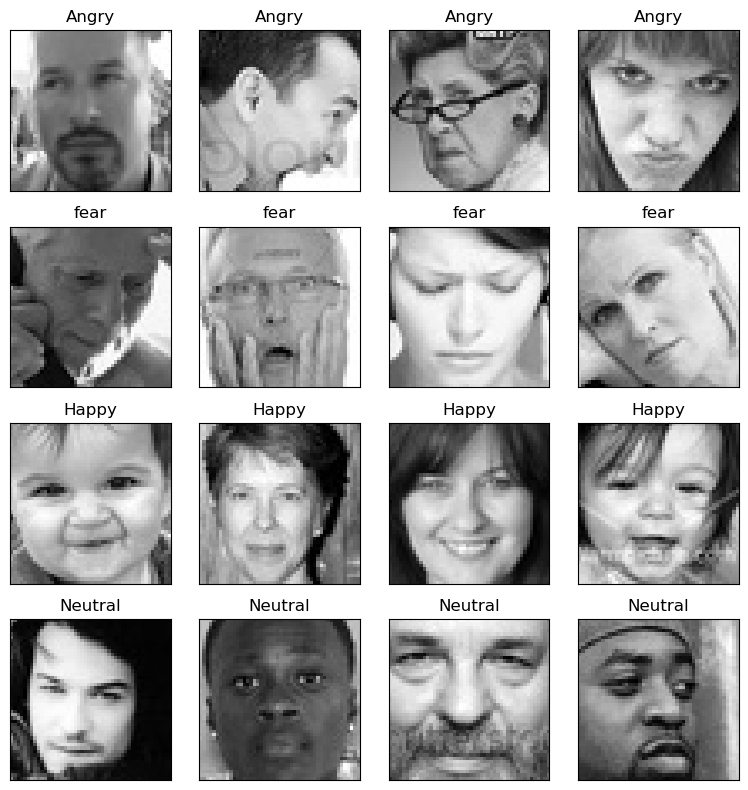

In [41]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [44]:
img_label = to_categorical(img_label)
img_label.shape

(16496, 4)

`Splitting the data into training and validation set.`

In [45]:
img_arr = img_arr / 255.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [47]:
del img_arr
del img_label

In [48]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [49]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

C:\Users\user\AppData\Local\Temp\ipykernel_4004\1014788097.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = MobileNet(


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [50]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [51]:
for layer in model.layers[:15]:
    layer.trainable = False

In [52]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [53]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [61]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks,
    
)

Epoch 1/40


C:\Users\user\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 196s 189ms/step - accuracy: 0.3737 - loss: 1.9549 - val_accuracy: 0.4788 - val_loss: 1.4342 - learning_rate: 0.0100
Epoch 2/40
  1/593 ━━━━━━━━━━━━━━━━━━━━ 1:32 157ms/step - accuracy: 0.7200 - loss: 0.9061

C:\Users\user\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7200 - loss: 0.9061 - val_accuracy: 0.4897 - val_loss: 1.3718 - learning_rate: 0.0100
Epoch 3/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 107s 180ms/step - accuracy: 0.5421 - loss: 1.1027 - val_accuracy: 0.5255 - val_loss: 1.4150 - learning_rate: 0.0100
Epoch 4/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6400 - loss: 0.8400 - val_accuracy: 0.5182 - val_loss: 1.4854 - learning_rate: 0.0100
Epoch 5/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 102s 170ms/step - accuracy: 0.6007 - loss: 0.9758 - val_accuracy: 0.6176 - val_loss: 0.9700 - learning_rate: 0.0100
Epoch 6/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6000 - loss: 0.8819 - val_accuracy: 0.6188 - val_loss: 0.9685 - learning_rate: 0.0100
Epoch 7/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 105s 176ms/step - accuracy: 0.6327 - loss: 0.9060 - val_accuracy: 0.4812 - val_loss: 1.3066 - learning_rate: 0.0100
Epoch 8/40
593/593 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5600 - loss: 0.8907 -

In [63]:
# Save model architecture as JSON
model_json = model.to_json()

# Optionally, save the JSON to a file
with open("model.json", "w") as json_file:
    json_file.write(model_json)


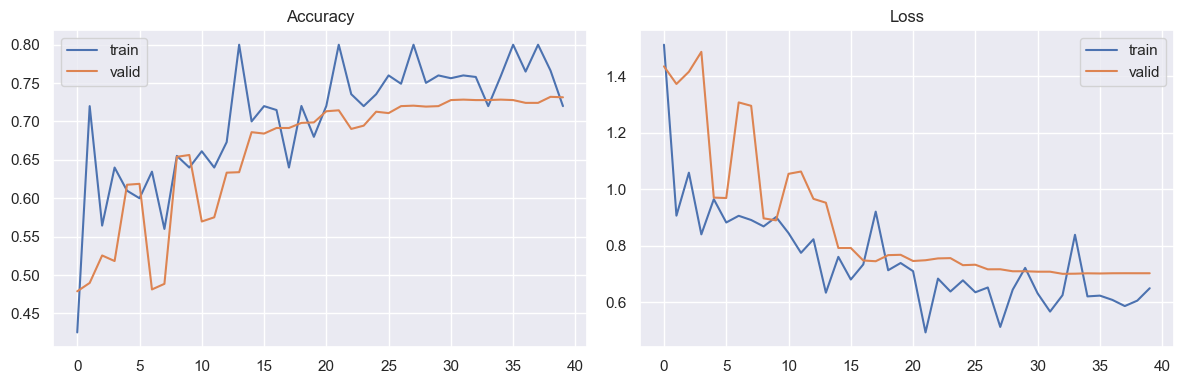

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set()

# Create a figure and axes
fig = plt.figure(figsize=(12, 4))

# First subplot: Accuracy
ax1 = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=ax1)
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=ax1)
ax1.set_title('Accuracy')
ax1.legend()

# Second subplot: Loss
ax2 = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=ax2)
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=ax2)
ax2.set_title('Loss')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Save and show the figure
plt.savefig('epoch_history_mobilenet.png')
plt.show()


In [66]:
label_to_text

{0: 'Angry', 1: 'fear', 2: 'Happy', 3: 'Neutral'}

In [67]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Angry': 0, 'fear': 1, 'Happy': 2, 'Neutral': 3}

52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step
test accuracy: 73.2121 %


              precision    recall  f1-score   support

           0       0.60      0.63      0.61       283
           1       0.68      0.45      0.54       253
           2       0.90      0.84      0.87       684
           3       0.63      0.80      0.70       430

    accuracy                           0.73      1650
   macro avg       0.70      0.68      0.68      1650
weighted avg       0.74      0.73      0.73      1650



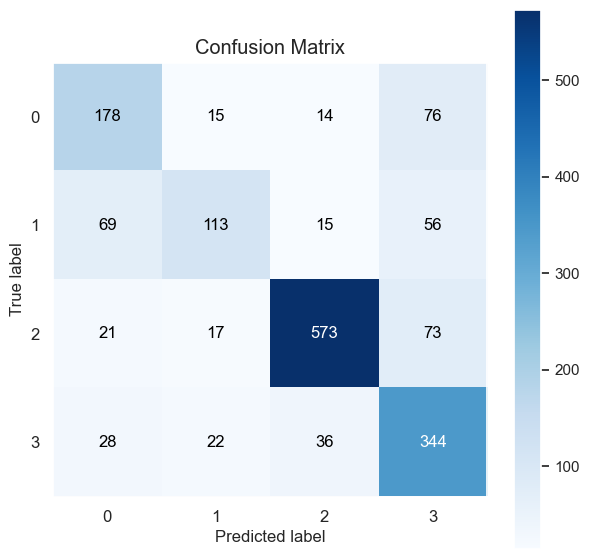

In [68]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to `happy`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


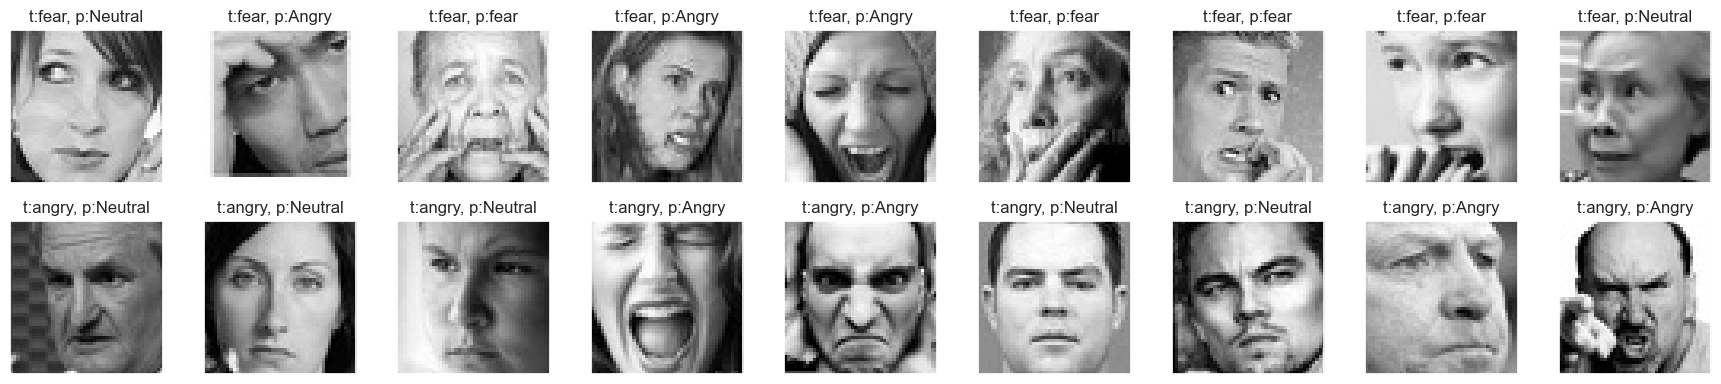

In [69]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

One of the reason for such low accuracy is the data quality. Below I have shown all the miss-classified images. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class.

In [70]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

total 69 miss labels out of 684 for emotion Happy


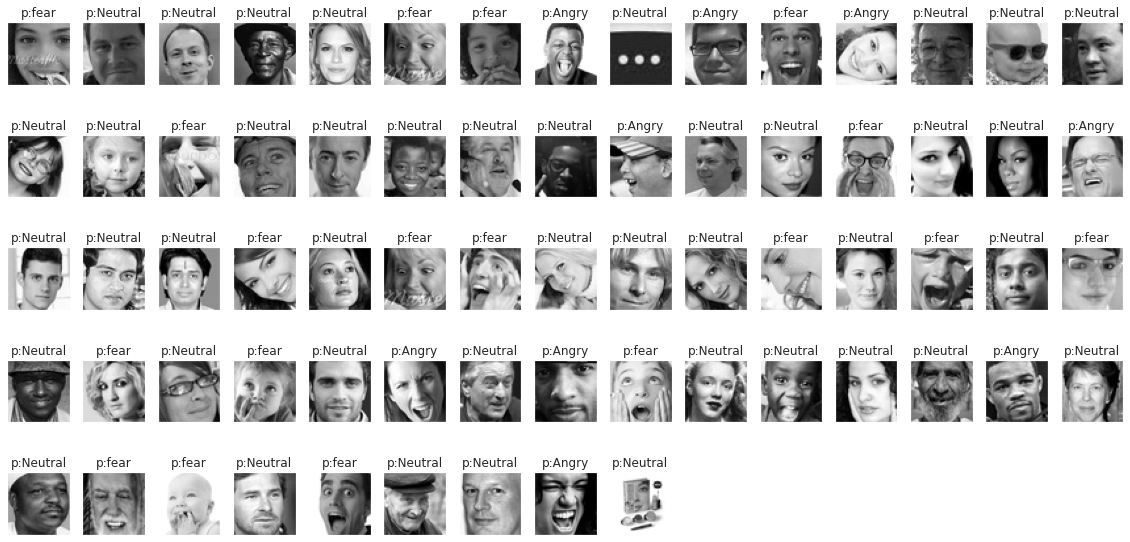

In [49]:
plot_miss_classified(emotion="Happy")

As we see most of these are classified as `fear` the reason for that is that most of the fear mouths are opened as we see earlier and many of these mouths are opened like that.

total 125 miss labels out of 253 for emotion fear


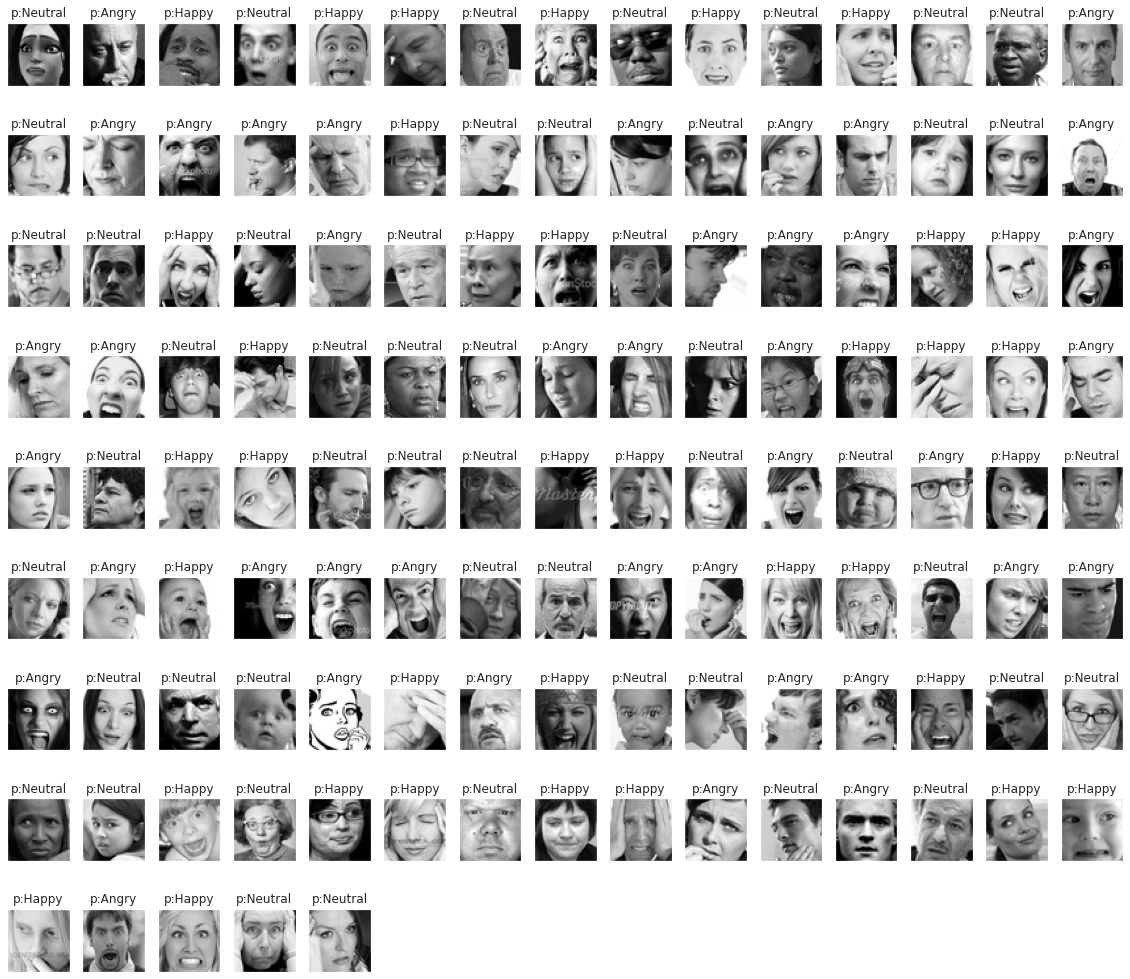

In [50]:
plot_miss_classified(emotion="fear")

total 105 miss labels out of 283 for emotion Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━

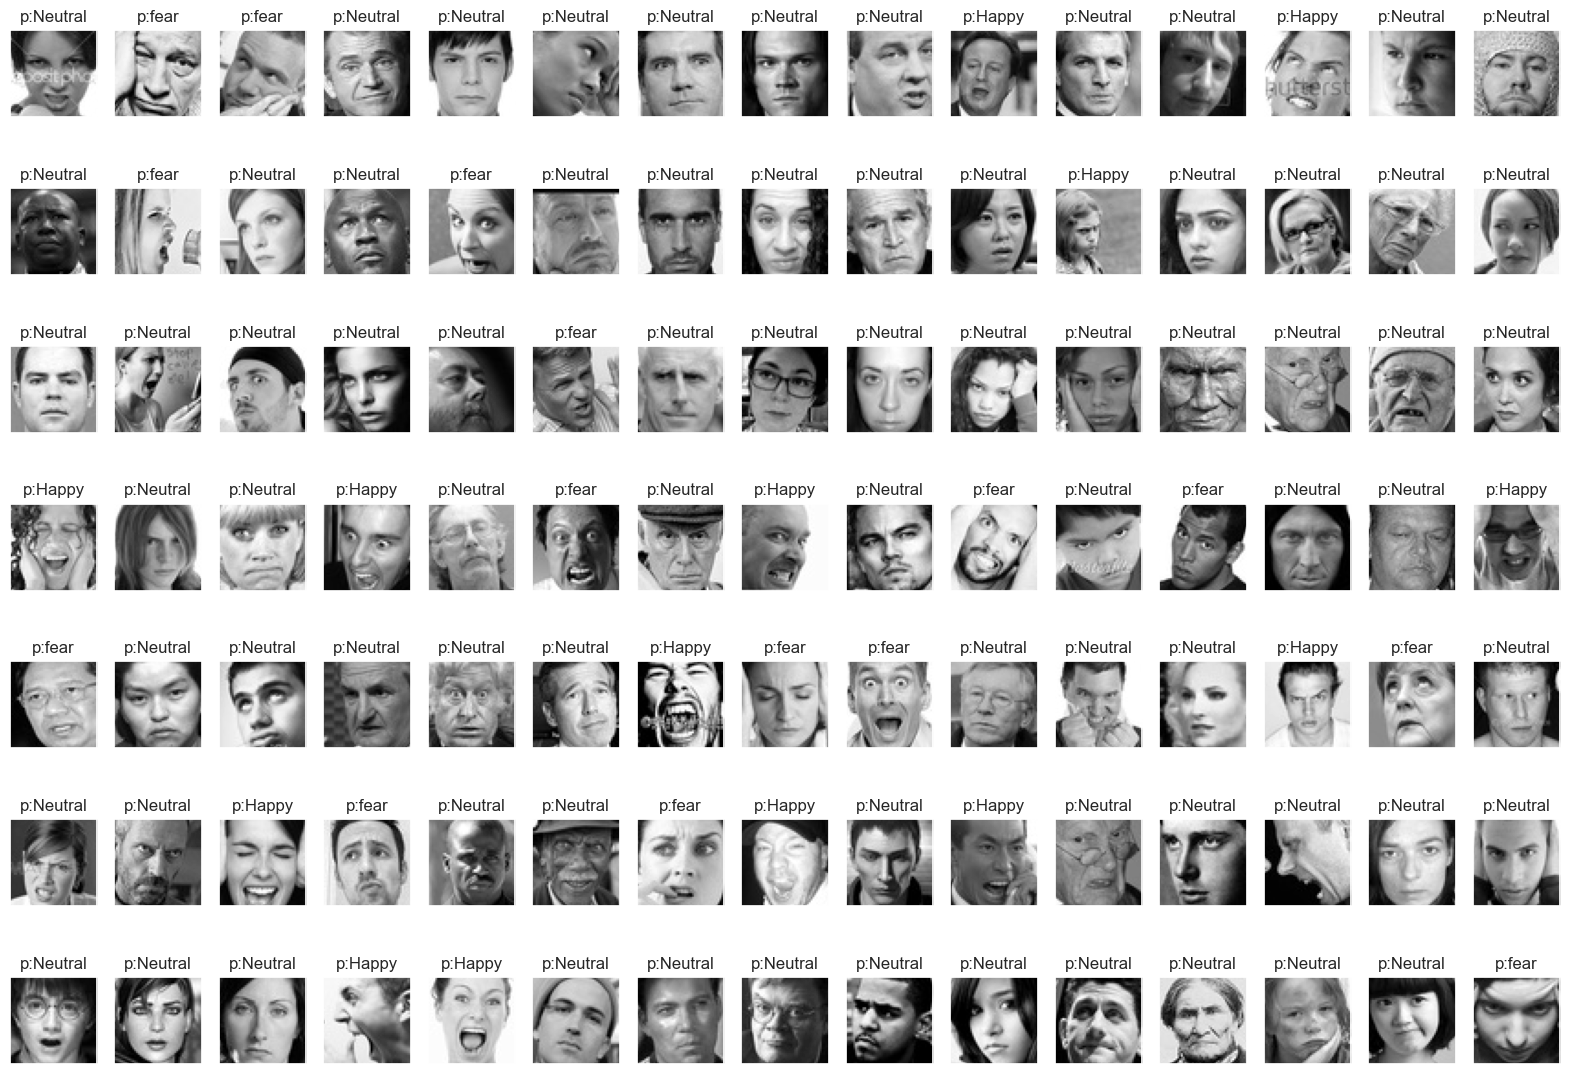

In [72]:
plot_miss_classified(emotion="Angry")

total 86 miss labels out of 430 for emotion Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━

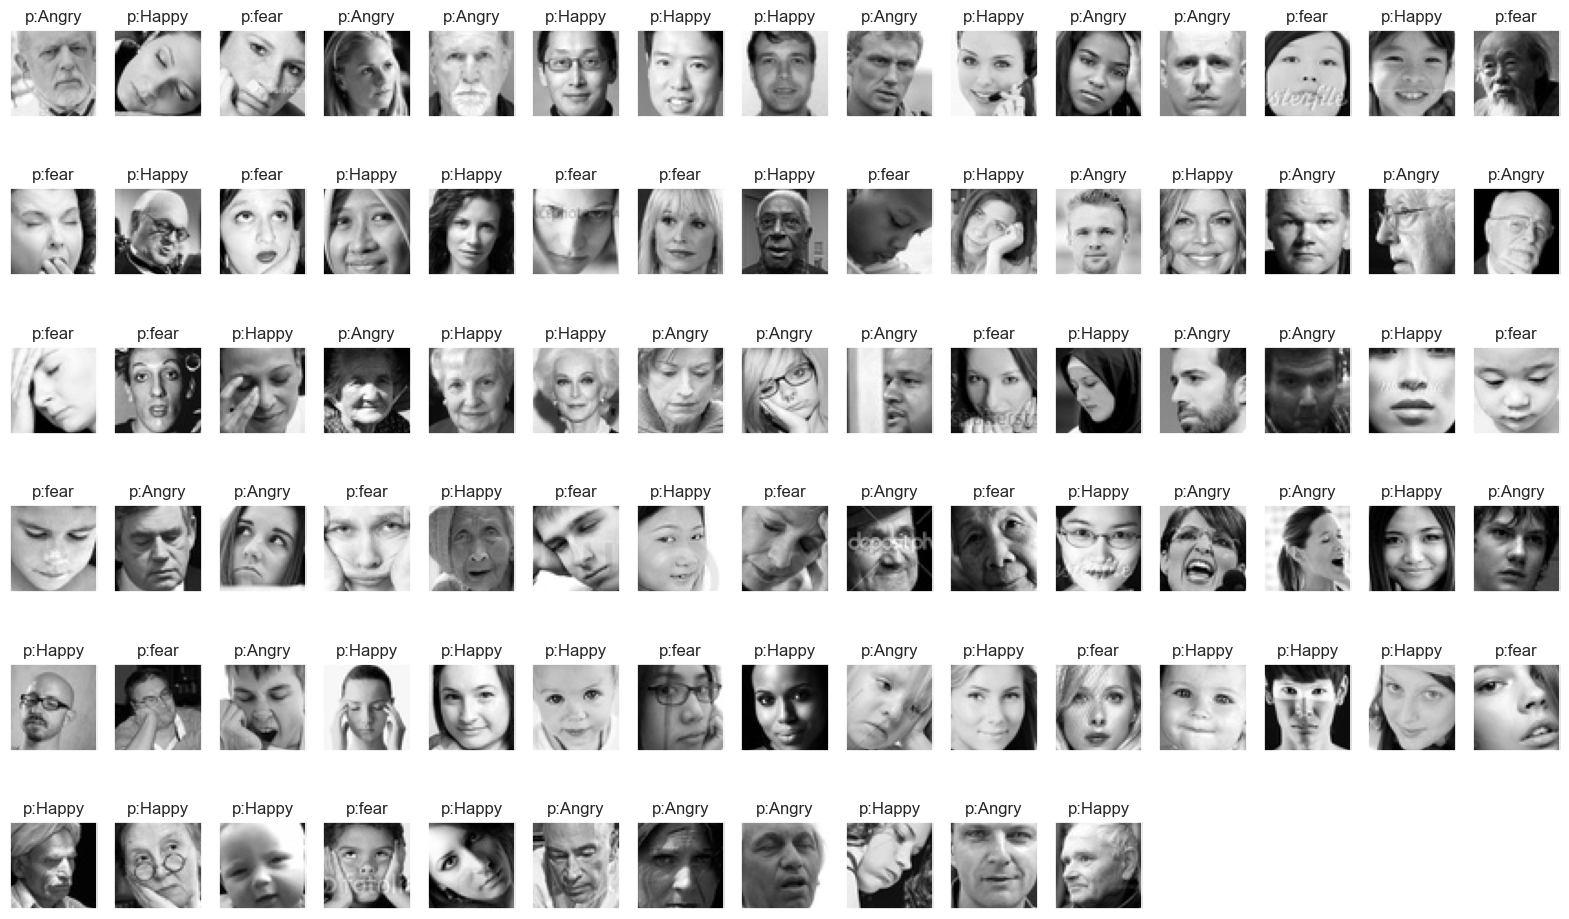

In [71]:
plot_miss_classified(emotion="Neutral")